The following script consists of a Python version of Andrew Ng Stanford Course 'Machine Learning' taught on the Coursera Platform
Note: All exercise data and structure are credited to Stanford University 

**Caveat:** Contrary to the modularity presented in Octave scripts and as I'm using Jupyter Notebooks for educational purposes we will implement the functions on the same notebook where we will call them

# Exercise 1 - Loading and Visualizing the Data

In [3]:
#Import numpy libraries to deal with matrixes and vectors
import numpy as np
#Import pandas do read data files
import pandas as pd
#Import matplotlib to plot data
import matplotlib.pyplot as plt

#Import math 
import math 

#Import scipy optimization function
from scipy import optimize, io
from scipy.ndimage import rotate

#Matplotlib notebook property
%matplotlib inline

In [4]:
#Define input layer Size and Number of labels (utcome space - 1 until 10 (10 mapped as 0))

input_layer_size = 400
num_labels = 10

In [5]:
#Use scipy Io to load matrix object
ex3_file = io.loadmat('ex3data1.mat')
X = np.array(ex3_file['X'])
y = np.array(ex3_file['y'])

print('# of training examples: {}'.format(len(X)))
m = len(X)

# of training examples: 5000


The data translates some portion of the MNIST dataset, translating vector representations of handrwritten digits. 
The data is unrolled into a 400 dimensional vector with grayscales intensity. By reshaping the data below we are going to be able to clearly see the digits themselves.

**We are going to plot 100 random digits**

In [6]:
#Select 100 random indices between 0 and 4999 
index = np.random.choice(X.shape[0], 101, replace=False) 

#Subset Array elements to Plot - using index
sel = X[index]

In [7]:
def displayData(images: np.array) -> None:
    '''
    Plot 10 by 10 grid of hand-written digit images
    '''
    fig=plt.figure(figsize=(10, 10))
    columns = 10
    rows = 10
    #Loop through each piece of the grid and plot the digit by reshaping the data into a 20 by 20 pixel image
    for i in range(1, sel.shape[0]):
        img = sel[i].reshape(20,20)
        fig.add_subplot(rows, columns, i)
        plt.imshow(rotate(img[::-1],270))
        plt.axis('off')
    plt.show()

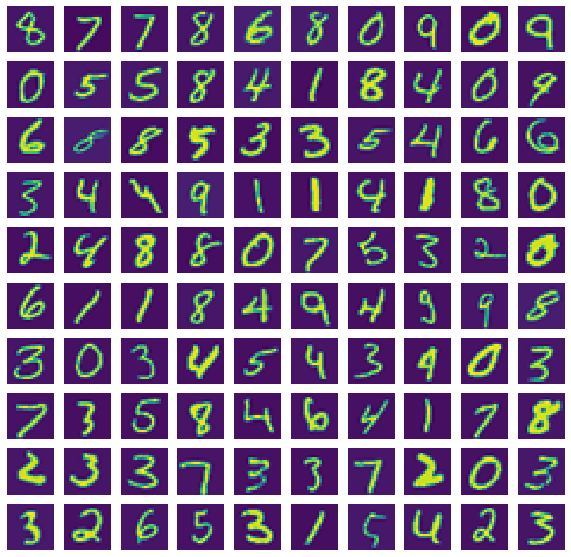

In [8]:
#Display the Grid

displayData(sel)

We want to develop a multi-class classification for Logistic Regression. Notice how the target is not binary 1 vs. 0 but a One vs. All approach. Each output will have the probability of a specific number beloging to a specific class (1-10)
Like Andrew, we will keep the 0 classed map for 10 although in Python this would not be a issue.

# Exercise 2 - Vectorized Logistic Regression

In [9]:
#Define parameters and fictional X_t and y_t to test the Vectorized Logistic Regression:

theta_t = np.array([-2, -1, 1, 2])
X_t = np.hstack((np.ones(5).reshape(5,1),np.linspace(1,15,15).reshape(5,3, order='F')/10))
y_t = np.array([1,0,1,0,1])
lambda_t = 3

In [10]:
#Define sigmoid function 
def sigmoid(x: np.array)-> np.array:
    '''
    Outputs the Sigmoid for each element of an array
    '''
    return(1 / (1 + np.exp(-x)))

We have to implement a regularized implementation of the Cost Function and Vectorization. This is similar to what we have did in former lessons:
   
<img src="assets/VectorizedLogisticRegression.JPG">
    

In [11]:
def lrCostFunction(theta: np.array, X: np.array, y:np.array, lambdas: int) -> (np.array, np.array):
    '''
    Regularized logistic regression implementation 
    
    Receives:
    - Theta parameter;
    - Feature vector;
    - output vector;
    - regularization parameter;
    
    Returns the regularized cost function and gradient
    '''
    m = len(y)
    n = X.shape[1]
    
    #Hypothesis calculation
    h = sigmoid(np.dot(X,theta))
    
    a = -y*np.log(h)
    b = (1-y)*np.log(1-h)
    
    regul = lambdas/(2*m)
    
    #Compute cost function
    J = (sum(a-b))*(1/m) + regul * sum(theta[1:]**2)
               
    grad_regul = np.zeros(n)
    
    grad_regul[1:] = (lambdas/m)*theta[1:]
    
    #Compute gradient
    grad = ((1/m)*(np.dot(X.T,(h-y))) + grad_regul)
    
    return J, grad
    

In [12]:
J, grad = lrCostFunction(theta_t, X_t, y_t, lambda_t)

In [13]:
print('Cost for test example: {} '.format(J))
print('Gradients for test example: {} '.format(grad))

Cost for test example: 2.534819396109744 
Gradients for test example: [ 0.15 -0.55  0.72  1.4 ] 


# Exercise 3 - One vs. All - Training

We need to optimize our Logistic Regression for each possible value of our outcome space. 
By developing a Logistic Regression for each outcome we can better capture the feature space that represents the drawing of that digit.

In [14]:
#Define lambda
lambdas = 0.1 

In [15]:
#Write one vs. all Classification function 

def oneVsAll(X: np.array, y: np.array, num_labels: int, lambdas: float) -> np.array:
    '''
    Function to develop regularized logistic regression for each label. 
    Reads four arguments:
    X - Feature Space;
    y - target;
    Num_Labels - num of different logistic regressions to train;
    lambdas - regularization parameter
    
    Outputs Thetas for each model for each digit
    '''
    
    m = X.shape[0]
    n = X.shape[1]
    
    #Add intercept
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    #Create placeholder for each theta
    all_theta = np.zeros((num_labels,n+1))
    
    #Options for optimization process
    options= {'maxiter': 100}
    
    #Create initial Theta
    init_theta = np.zeros((m,1))
    
    #Loop through each label and optimize the cost function for each one - Rewrite the Placeholder with the optimal theta found by the optimizer
    for label in np.arange(1,num_labels):
        init_theta = np.zeros((n+1,1))
        target = np.array([1 if val == True else 0 for val in y==label])
        res = optimize.minimize(lrCostFunction,
                        init_theta,
                        (X_extended, target, lambdas),
                        jac=True,
                        method='TNC',
                        options=options)
    
        all_theta[label-1,:] = res.x.T
    return all_theta

In [16]:
all_theta = oneVsAll(X, y, num_labels, lambdas)

In [17]:
def predictOnevsAll(all_theta: np.array, X: np.array, num_labels: int)-> np.array:
    '''
    Predict one vs. all and output probability of digit being each outcome (0 to 9)   
    '''
    m = X.shape[0]

    #Add intercept
    ones_vector = np.ones((len(X),1))
    X_extended = np.hstack((ones_vector,X))
    
    return sigmoid(np.dot(X_extended, all_theta.T))

In [18]:
#Get Predicted Vector
predicted = predictOnevsAll(all_theta, X, num_labels)

In [19]:
#Assign max probability to the predicted digit - Remember that 10 = 0 
result = (np.argmax(predicted, axis=1)+1).reshape(predicted.shape[0],1)

In [20]:
print("Accuracy is {} ".format(sum(np.array([1 if val == True else 0 for val in result==y]))/len(y)))

Accuracy is 0.9162 
